# 1. Introdução

Esse trabalho visa realizar a previsão dos valores futuros de fechamento do índice IBOVESPA através de algoritmos de machine learning voltados para problemas de Time Series.

# 2. Objetivo

Primeiramente fazer uma análise exploratória robusta em busca de aprimorar o entendimento dos dados e depois realizar testes utilizando os algoritmos MA, ARIMA e Prophet para verificar a acurácia dos modelos.

# 3. Premissas

Atingir uma acuracidade acima de 70%.

# 4. Desenvolvimento

### Imports realizados

In [2]:
# Imports Gerais

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import plotly.graph_objects as go


# Imports ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf     
from statsmodels.tsa.arima.model import ARIMA  

# Imports Prophet
from prophet import Prophet



c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carregamento dos Dados

In [3]:
# Parâmetros
symbol= '^BVSP'
start_date = '2000-01-01'
end_date = '2024-01-20'

# Obtendo os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,17098.0,17408.0,16719.0,16930.0,16930.0,0
2000-01-04,16908.0,16908.0,15851.0,15851.0,15851.0,0
2000-01-05,15871.0,16302.0,15350.0,16245.0,16245.0,0
2000-01-06,16237.0,16499.0,15977.0,16107.0,16107.0,0
2000-01-07,16125.0,16449.0,16125.0,16309.0,16309.0,0


In [5]:
# Verificando a estrutura do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5954 entries, 2000-01-03 to 2024-01-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5954 non-null   float64
 1   High       5954 non-null   float64
 2   Low        5954 non-null   float64
 3   Close      5954 non-null   float64
 4   Adj Close  5954 non-null   float64
 5   Volume     5954 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 325.6 KB


In [6]:
# Resetando o index e convertendo para datetime

df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) 


In [7]:
df_ibovespa = df.sort_values(by='Date', ascending=True)

### Visualizando a série do índice IBOVESPA

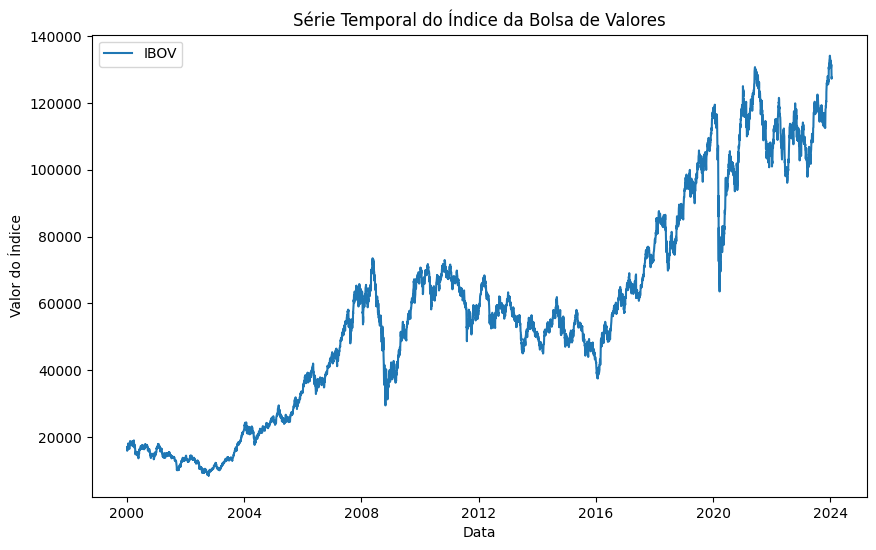

In [8]:
# Plotando a série temporal

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(df_ibovespa['Date'], df_ibovespa['Close'], label = 'IBOV')
plt.title('Série Temporal do Índice da Bolsa de Valores')
plt.xlabel('Data')
plt.ylabel('Valor do Índice')
plt.legend(loc='best')
plt.show()

Analisando o gráfico verificamos nos anos de 2009 e 2020 as duas principais quedas abruptas no indice que representam, respectivamente, a **crise de 2009 e a pandemia global causada pela COVID-19**. 

Como pode ser visto destacado na imagem abaixo:

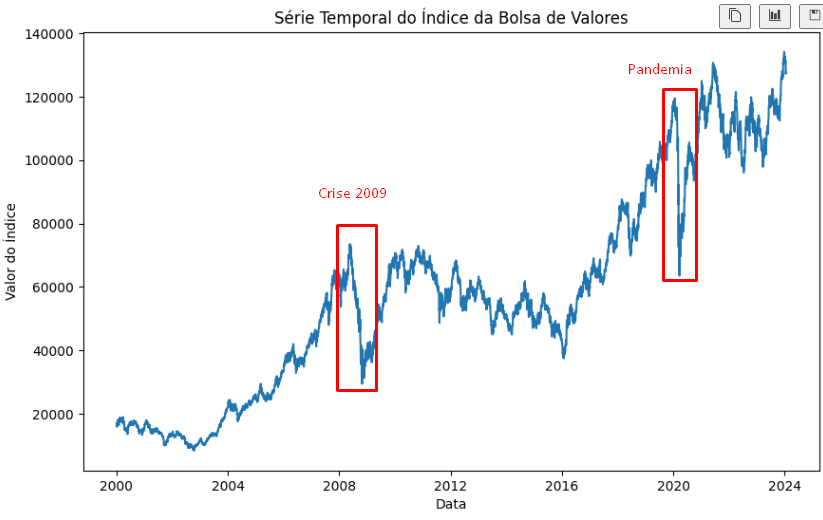

### Análise Exploratória dos dados

Iremos primeiramente decompor a série temporal para analisar a **Tendência, Sazonalidade e Ruído**. 

Para isso utilizaremos a biblioteca Statsmodel, e essas informações serão cruciais na escolha do modelo ideal para realizar a predição.

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_18820\2973951508.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_eda = df_eda.asfreq('D').fillna(method='ffill')


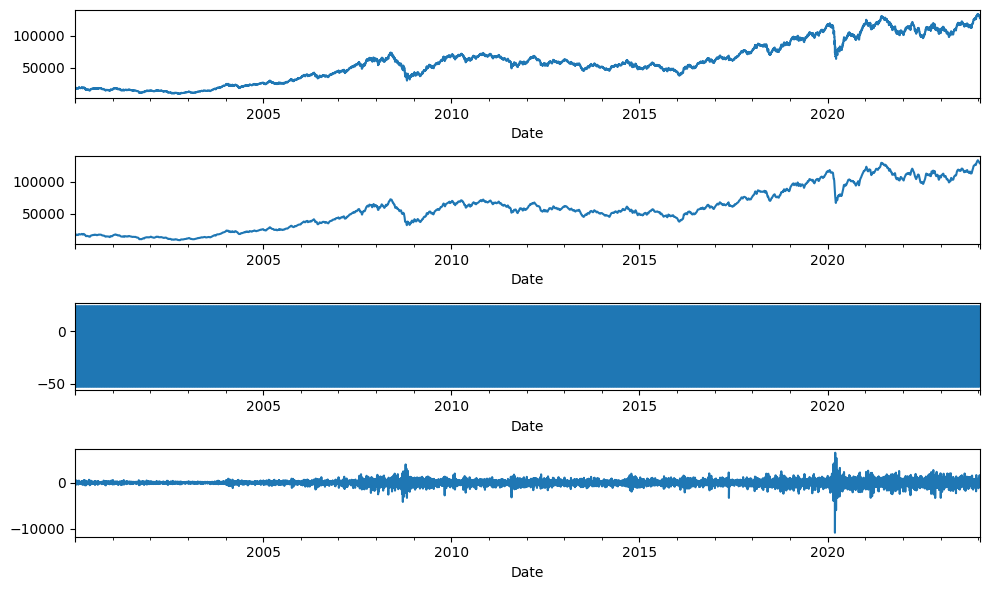

In [9]:
# Criando uma nova view para o dataframe original não ser comprometido com a análise
df_eda = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date')

# Preenchendo os dias faltantes (FDS + Feriados)
df_eda = df_eda.asfreq('D').fillna(method='ffill')


# Decompondo a série temporal
resultados = seasonal_decompose(df_eda)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Analisando a decomposição da série temporal, podemos observar que:

> **Tendência:** Embora haja bastante variabilidade, é possível observar que a tendência é de alta.

> **Sazonalidade:** O gráfico nos mostra que não existe uma sazonalidade clara no comportamento do índice.

> **Ruído:** Percebemos que os maiores ruídos foram causados nas duas quedas abruptas mencionadas anteriormente e que tirando isso, ele é totalmente aleatório.


Analisamos os últimos dois anos para entender melhor as variações do mercado.

In [10]:
df_atual = df_eda[-730:]
df_atual

,Close
Date,
2022-01-20,109102.0
2022-01-21,108942.0
2022-01-22,108942.0
2022-01-23,108942.0
2022-01-24,107752.0
...,...
2024-01-15,131521.0
2024-01-16,129294.0
2024-01-17,128524.0


In [11]:
data_min = df_atual.index.min()
data_max = df_atual.index.max()

print(f'Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia {data_min} e finaliza-se no dia {data_max}')

Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia 2022-01-20 00:00:00 e finaliza-se no dia 2024-01-19 00:00:00


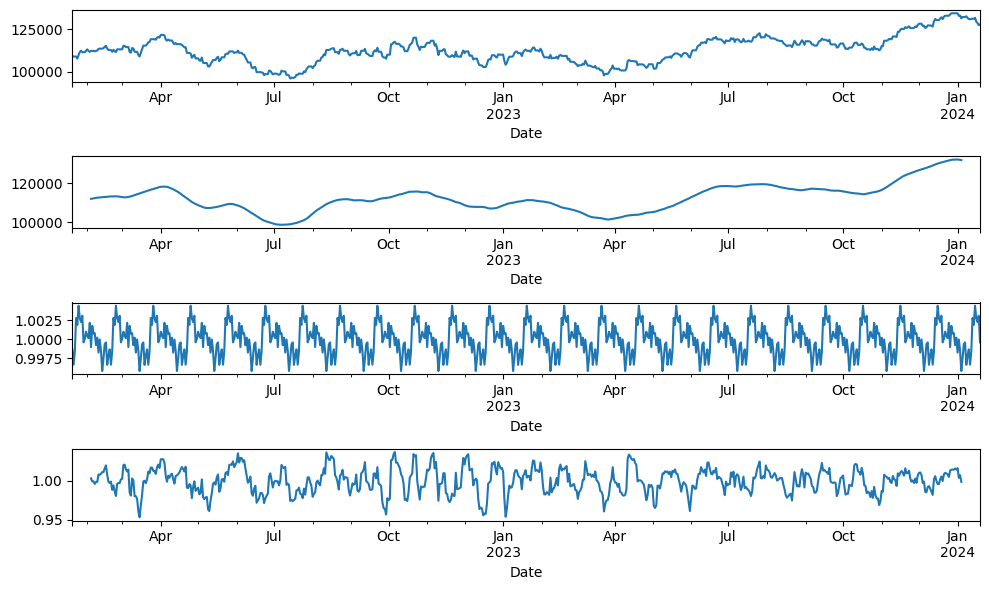

In [12]:
# Decompondo a série temporal
resultados = seasonal_decompose(df_atual, model='multiplicative', period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Analisando a decomposição da nova série temporal, podemos observar que:

> **Tendência:**  Permance sendo de alta.

> **Sazonalidade:**  Aparentemente existe uma ciclicidade, mas acreditamos que possa ser causada pelo método *"asfreq('D').fillna(method='ffill')"* que utilizamos para fazer o preenchimento dos feriados e finais de semana

> **Ruído:** Percebemos que retirando o período das quedas abruptas, muda bastante.

Repetiremos o processo utilizando o método de interpolação para o preenchimento das datas

In [13]:
df_atual2 = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date').asfreq('D').interpolate(method='linear')[-730:]

data_min2 = df_atual2.index.min()
data_max2 = df_atual2.index.max()

print(f'Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia {data_min2} e finaliza-se no dia {data_max2}')

Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia 2022-01-20 00:00:00 e finaliza-se no dia 2024-01-19 00:00:00


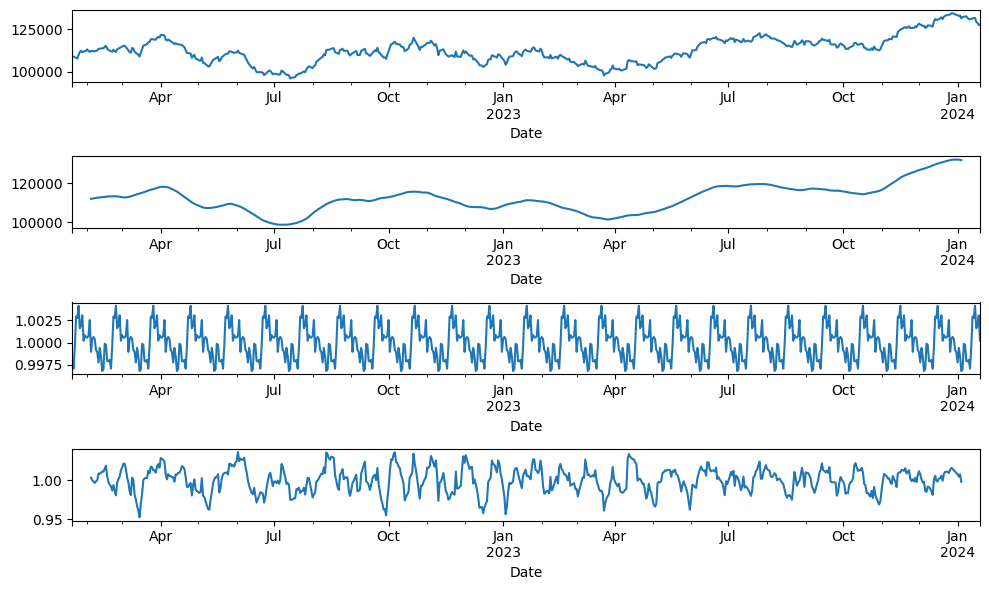

In [14]:
# Decompondo a série temporal
resultados = seasonal_decompose(df_atual2, model='multiplicative', period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Analisando a decomposição da série temporal utilizando o método de interpolação, podemos observar que:

Não houveram modificações tão significativas na decomposição.

Como último método, utilizaremos a decomposição sem inferir valores.

In [15]:
# Como último método, utilizaremos a decomposição sem inferir valores.

df_atual3 = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date')[-730:]

data_min3 = df_atual3.index.min()
data_max3 = df_atual3.index.max()

print(f'Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia {data_min3} e finaliza-se no dia {data_max3}')

Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia 2021-02-17 00:00:00 e finaliza-se no dia 2024-01-19 00:00:00


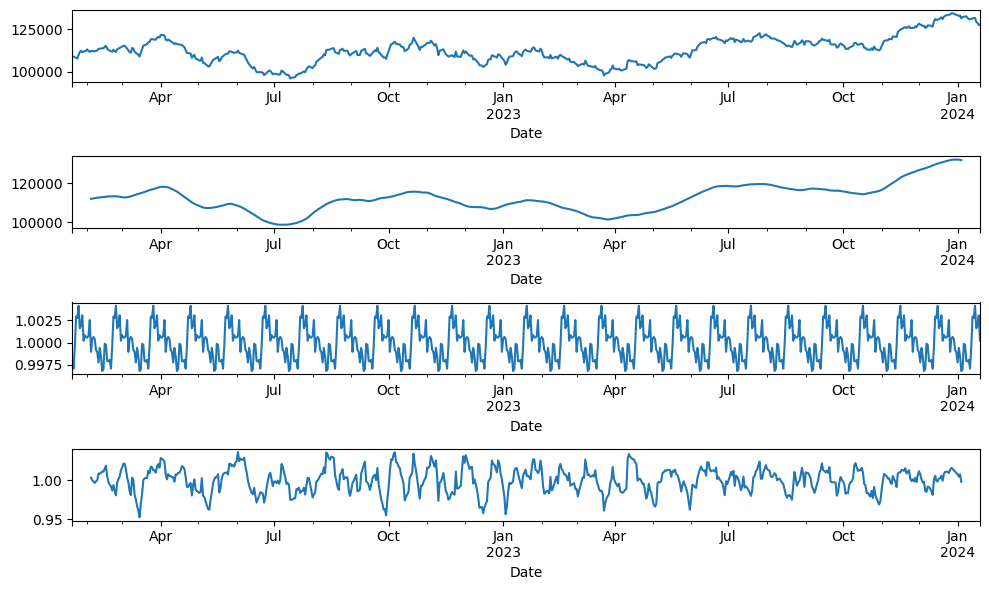

In [16]:
import statsmodels.api as sm

# Decompondo a série temporal com o tsa
resultados = sm.tsa.seasonal_decompose(df_atual2, model='multiplicative',  period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Foi observado que mesmo retirando os valores "inputados forçadamente" o comportamento permaneceu. 

Portanto assumiremos que existe sazonalidade, mas na série real, esta é muito impactada pelos ruídos.

**Seguiremos com a análise exploratória sem inputar valores no entanto utilizando a base inteira para análise.** 

Para isso, resgataremos o nosso df_eda e não utilizaremos nenhum método de "fill" (preenchimento), usando também o statsmodels.tsa.seasonal.

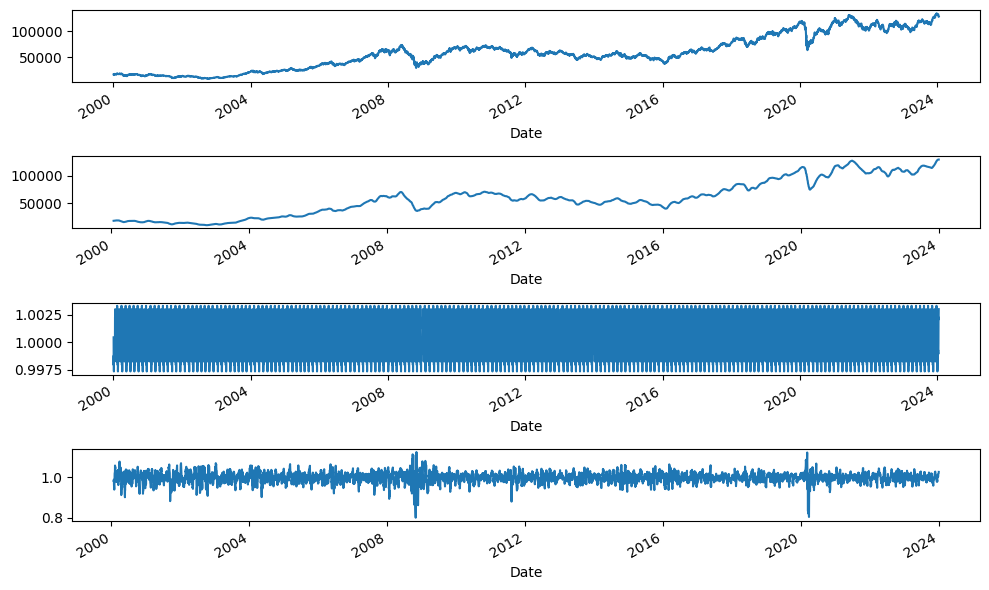

In [17]:
# Criando uma nova view para o dataframe original não ser comprometido com a análise
df_eda_2 = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date')

# Decompondo a série temporal
resultados = sm.tsa.seasonal_decompose(df_eda_2, model='multiplicative',  period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

> Especialistas e portais renomados do mercado apontam que a tendência de curto prazo é de alta, o que valida as análises anteriormente realizadas.

https://www.infomoney.com.br/mercados/analise-tecnica-ibovespa-opera-em-tendencia-de-alta-no-curto-prazo-mira-os-131-mil-pontos-mas-com-correcoes-no-caminho/

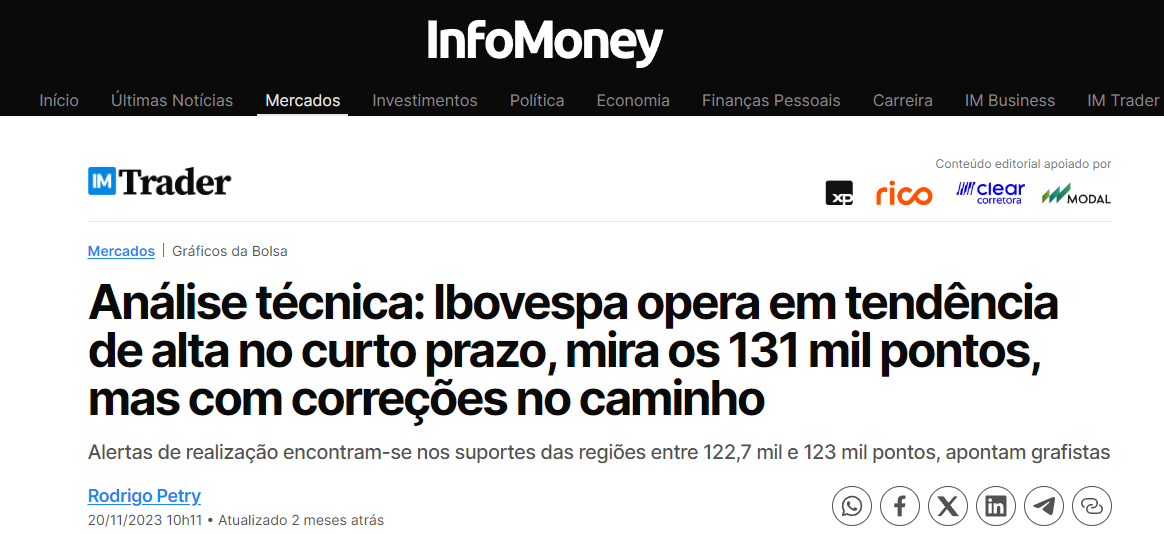

A presença de ruídos também é justificada pela forma como esse mercado é impactado por fatores externos, como por exemplo o plano industrial que fez com que o indice caísse em quase 1%.

https://www.moneytimes.com.br/ibovespa-hoje-fecha-queda-plano-industria-300-bi-vale-vale3-bancos-22-01-2024/

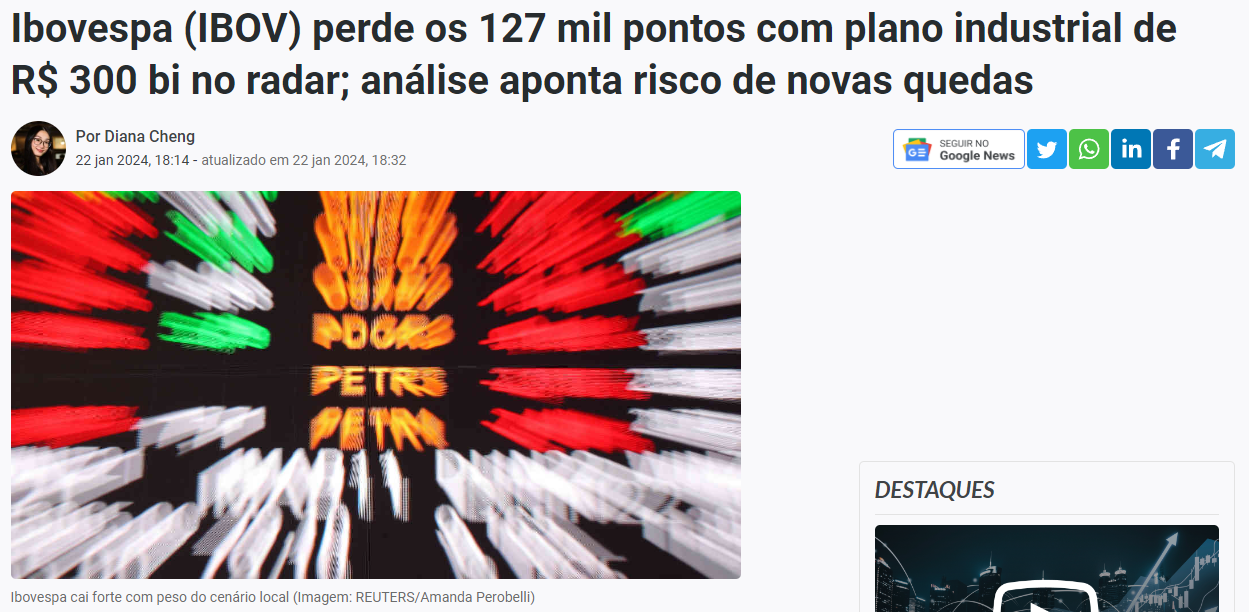



### Desenvolvendo o Modelo de Predição

Começaremos pelo modelo clássico de **Média Móvel.** 

Vamos utilizar esta técnica para um N de 5 dias, que seria o período de 1 semana da bolsa de valores.

In [18]:
df = pd.DataFrame(df[['Close','Date']])
df.set_index('Date', inplace=True)


In [19]:
df['MA_window_5'] = df['Close'].rolling(5).mean().shift() 

In [20]:
df.head(10) # Os primeiros 5 valores ficarão nulos.

,Close,MA_window_5
Date,,
2000-01-03,16930.0,NaN
2000-01-04,15851.0,NaN
2000-01-05,16245.0,NaN
2000-01-06,16107.0,NaN
2000-01-07,16309.0,NaN
2000-01-10,17022.0,16288.4
2000-01-11,16573.0,16306.8
2000-01-12,16617.0,16451.2
2000-01-13,17298.0,16525.6


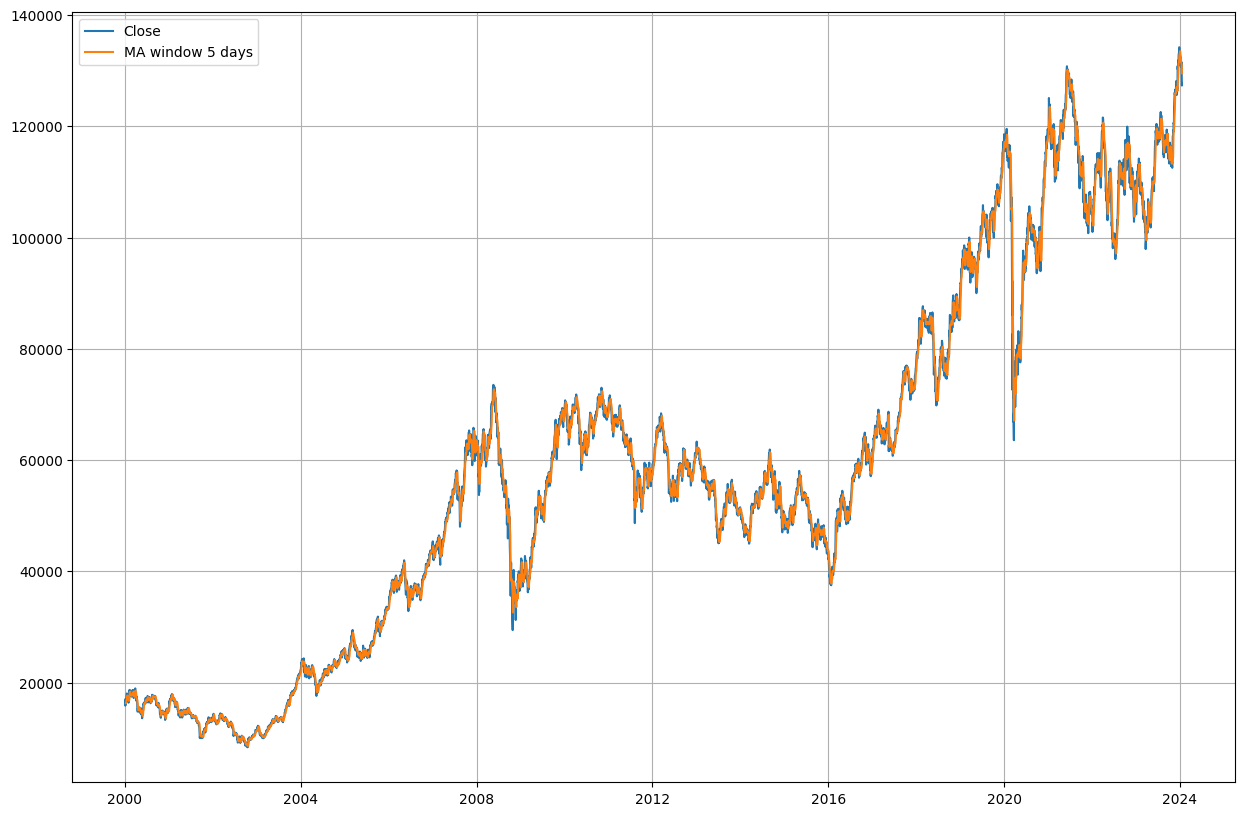

In [21]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_window_5'], label='MA window 5 days')
plt.legend(loc='best')
plt.show()

Reduzimos a base para verificar o mesmo modelo para apenas o último ano. 

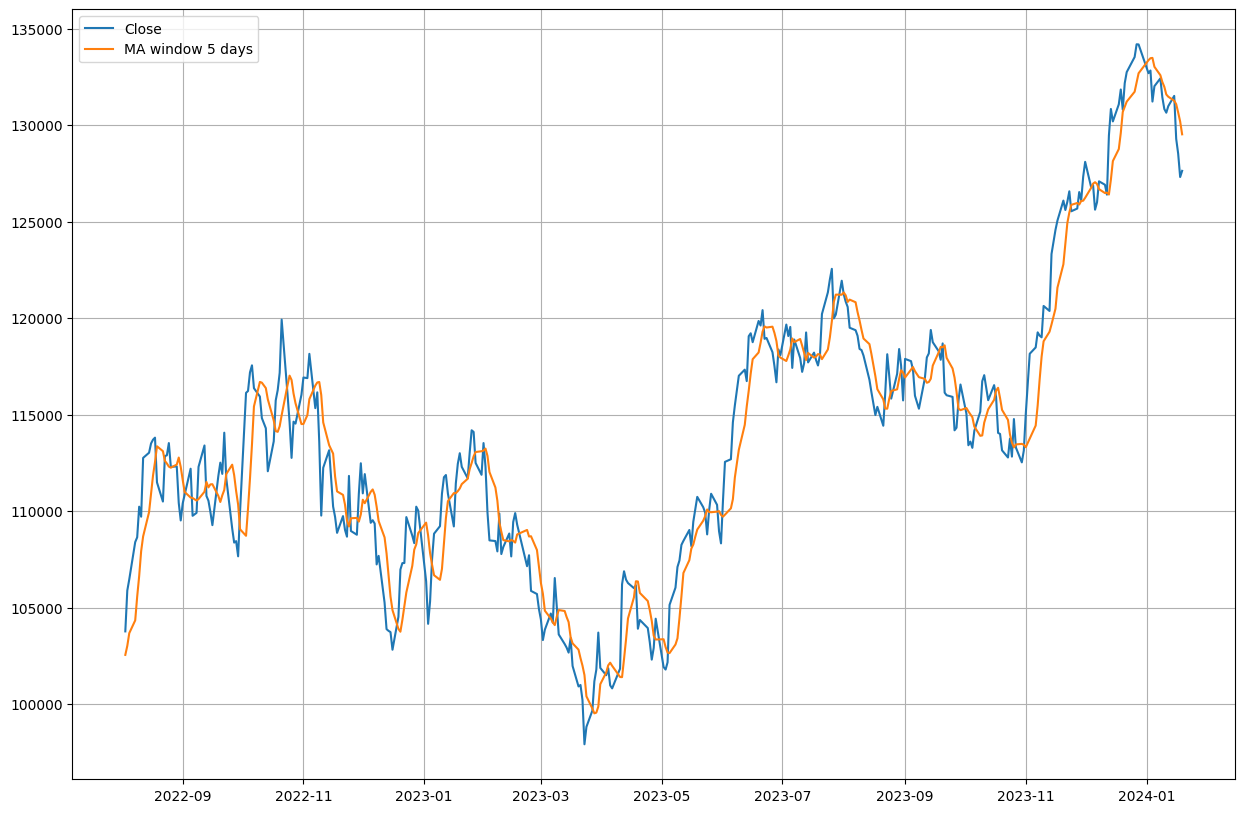

In [22]:
dias = 365

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'][-dias:], label='Close')
plt.plot(df['MA_window_5'][-dias:], label='MA window 5 days')
plt.legend(loc='best')
plt.show()

Construindo o modelo

In [23]:
# Preechendo com NaN os valores da coluna de MA_window_5_forward_5

df['MA_window_5_forward_5'] = np.NaN 

In [24]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)] 

In [25]:
window_size = 5
forward_days = 5

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_5_forward_5'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_5_forward_5')] = mean


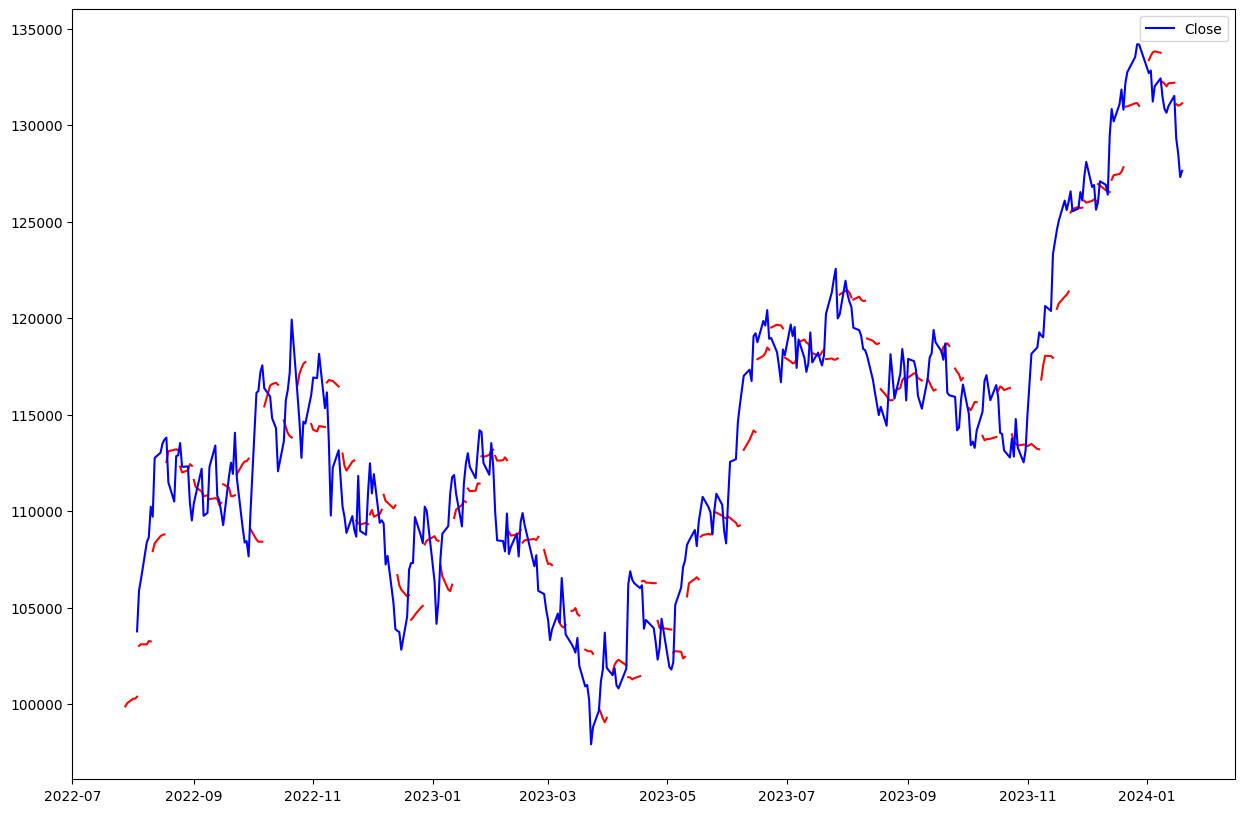

In [26]:
plt.figure(figsize = (15,10))

size = len(df)-dias - (len(df)-dias)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_5_forward_5'][index:index+forward_days], color='r')

plt.plot(df['Close'][-dias:], color='b', label='Close')
plt.legend(loc='best')
plt.show()

Com a análise das retas vermelhas, verificamos que o algoritmo não previu com margem de erro aceitável. 

Para escolher o modelo ideal, faremos o teste para verificar a estacionariedade através do Teste de Dickey-Fuller Aumentado (ADF).

In [27]:
# Teste de ADF para verificar estacionariedade

adf_result = adfuller(df_eda_2['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -0.6860540960010798
p-value: 0.8503288474200337
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -0.6860540960010798
Valor-p: 0.8503288474200337
Valores Críticos:
   1%: -3.4314509975133816
   5%: -2.862026538823416
   10%: -2.5670289822848287


Verificamos que a nossa **Série Temporal no momento não é estacionária** porque o valor do 'p' está muito alto e o valor do Teste Estatístico está muito maior do que os valores críticos.

Transformamos a série em estacionária para utilizarmos o modelo ARIMA através da subrtação da média móvel dos dados transformados pela transformação logarítmica.

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

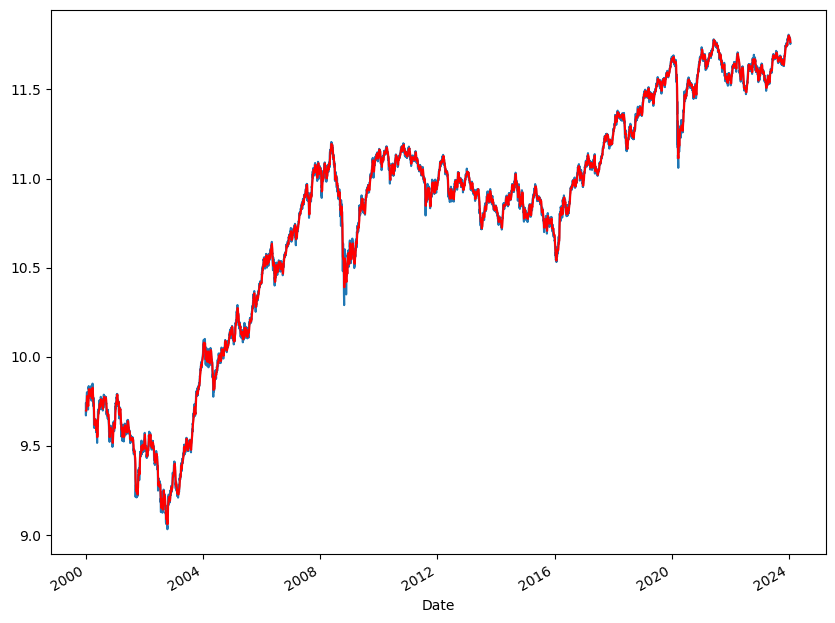

In [28]:
# Aplicando logaritimo

df_indice_log = np.log(df_eda_2)
ma_log = df_indice_log.rolling(5).mean()


f, ax = plt.subplots(figsize=(10,8))
df_indice_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r') 
plt.tight_layout

Nota-se que a escala diminui drásticamente, suavizando a série.

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

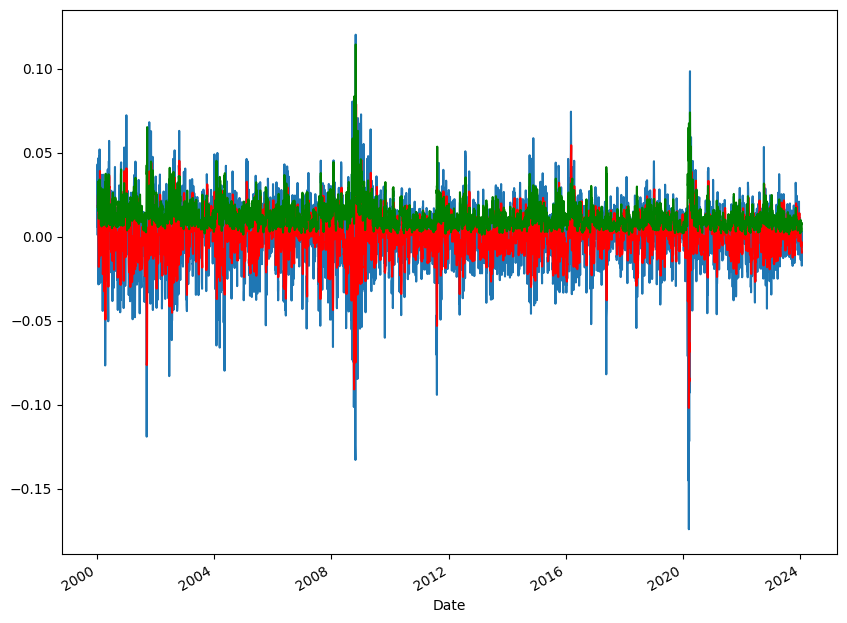

In [29]:
# Subtraindo a média móvel.

df_s = (df_indice_log - ma_log).dropna()

ma_s = df_s.rolling(5).mean()

std = df_s.rolling(5).std()

f, ax = plt.subplots(figsize=(10,8))
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r') 
std.plot(ax=ax, legend=False, color='g') 
plt.tight_layout

In [30]:
# Verificando novamente o teste de ADF

result_s = adfuller(df_s.Close.values)

print('Teste ADF')
print(f'Teste Estatístico: {result_s[0]}')
print(f'P-Value: {result_s[1]}')
print('Valores críticos:')

for key, value in result_s[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste Estatístico: -16.674227788720174
P-Value: 1.5356825758227012e-29
Valores críticos:
	1%: -3.4314526683830535
	5%: -2.8620272770559723
	10%: -2.567029375266065


Verificamos que agora o p-Value está muito próximo de 0 e que o Teste Estatístico está muito menor do que os valores críticos, **o que sugere estacionariedade.**

**Com os dados estacionarios, verificamos as Autocorrelações.**

In [31]:
lag_acf = acf(df_s, nlags=20)
lag_pacf = pacf(df_s, nlags=20, method='ols')

In [32]:
# Intervalo de confiança para o ACF/PACF
ci = 1.96/np.sqrt(len(df_s))

trace_acf = go.Scatter(x = np.arange(len(lag_acf)),y = lag_acf, mode='lines', name='ACF')
trace_pacf = go.Scatter(x = np.arange(len(lag_pacf)),y = lag_pacf, mode='lines', name='PACF')

# Linhas de intervalo de confiança superior e inferior
trace_ci_upper = go.Scatter(x = np.arange(len(lag_acf)),y = [ci]*len(lag_acf), mode='lines', name='Confidence Interval Upper Bound', line=dict(dash='dash', color='gray'))
trace_ci_lower = go.Scatter(x = np.arange(len(lag_acf)),y = [-ci]*len(lag_acf), mode='lines', name='Confidence Interval Lower Bound', line=dict(dash='dash', color='gray'))


fig_acf = go.Figure(data=[trace_acf, trace_ci_upper, trace_ci_lower])
fig_pacf = go.Figure(data=[trace_pacf, trace_ci_upper, trace_ci_lower])

fig_acf.show()
fig_pacf.show()


**No gráfico ACF**, percebemos que a curva toca a linha y=0,0 em x=7. **Portanto Q =7**

**No gráfico de PACF**, percebemos que a curva toca a linha y=0,0 em x=4. **Portanto P =4**

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Text(0.5, 1.0, 'RSS: 1.1718')

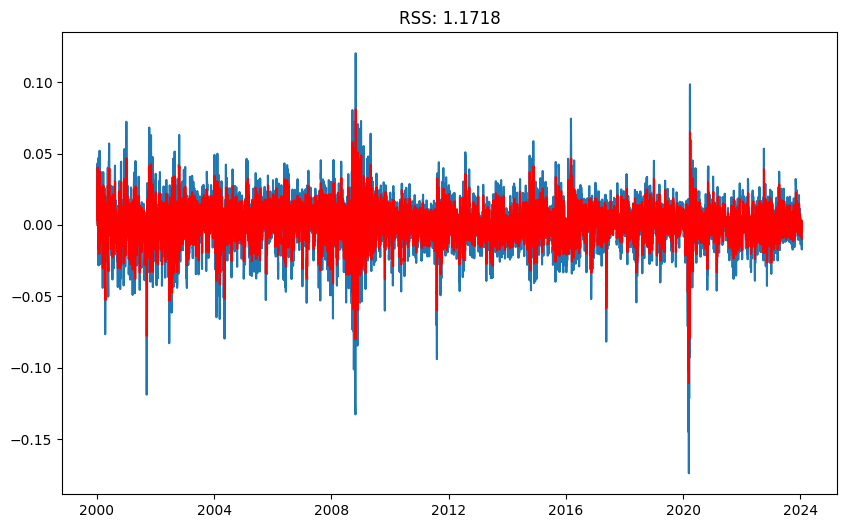

In [33]:
#AR Model
model = ARIMA(df_s, order=(4,1,7))#(p,d,q)
results_AR = model.fit()
plt.plot(df_s)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_s['Close'])**2))


**Validamos o modelo utilizando o MAPE.**

In [34]:
from sklearn.metrics import mean_absolute_error

# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = df_s.index

# Inverta a diferenciação
predicted_values = df_indice_log['Close'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(df_s['Close'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 1198.71%


Com esse resultado de MAPE, aparentemente as **previsões desse modelo estão muito distantes dos valores de fechamento da bolsa reais.**

**Utilizamos então outro modelo mais robusto chamado Prophet**.

In [35]:
# Renomeando as colunas para ds e y

df_prophet = df_eda_2.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
df_prophet.head()

,ds,y
0,2000-01-03,16930.0
1,2000-01-04,15851.0
2,2000-01-05,16245.0
3,2000-01-06,16107.0
4,2000-01-07,16309.0


In [36]:
# Dividindo a base entre treino e teste

split_point = int(len(df_prophet) * 0.9)
treino = df_prophet.iloc[:split_point]
valid = df_prophet.iloc[split_point:]
print(f'Treino : {treino.shape}')
print(f'Valid: {valid.shape}')

Treino : (5358, 2)
Valid: (596, 2)


In [37]:
# Fazendo o treinamento do modelo

modelo = Prophet(daily_seasonality=True)
modelo.fit(treino)

dataFramefuture = modelo.make_future_dataframe(periods=90, freq='D')

previsao = modelo.predict(dataFramefuture)
previsao

18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:56:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-03,16837.410000,13259.995368,25527.129455,16837.410000,16837.410000,2557.784896,2557.784896,2557.784896,800.814683,...,32.544111,32.544111,32.544111,1724.426102,1724.426102,1724.426102,0.0,0.0,0.0,19395.194896
1,2000-01-04,16830.235794,13156.056650,25662.353595,16830.235794,16830.235794,2616.190505,2616.190505,2616.190505,800.814683,...,26.641655,26.641655,26.641655,1788.734167,1788.734167,1788.734167,0.0,0.0,0.0,19446.426299
2,2000-01-05,16823.061589,12836.337109,26094.410527,16823.061589,16823.061589,2690.939345,2690.939345,2690.939345,800.814683,...,41.578169,41.578169,41.578169,1848.546493,1848.546493,1848.546493,0.0,0.0,0.0,19514.000934
3,2000-01-06,16815.887383,13322.339519,25810.455024,16815.887383,16815.887383,2744.450646,2744.450646,2744.450646,800.814683,...,40.776728,40.776728,40.776728,1902.859235,1902.859235,1902.859235,0.0,0.0,0.0,19560.338029
4,2000-01-07,16808.713177,13326.186676,26286.877315,16808.713177,16808.713177,2810.230607,2810.230607,2810.230607,800.814683,...,58.663223,58.663223,58.663223,1950.752701,1950.752701,1950.752701,0.0,0.0,0.0,19618.943784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5443,2021-11-21,123163.847635,117907.279069,130377.355578,123107.651685,123424.554685,975.475894,975.475894,975.475894,800.814683,...,-100.102040,-100.102040,-100.102040,274.763251,274.763251,274.763251,0.0,0.0,0.0,124139.323528
5444,2021-11-22,123198.092058,117757.107717,131040.115017,123125.875856,123472.544978,1147.713263,1147.713263,1147.713263,800.814683,...,32.544111,32.544111,32.544111,314.354469,314.354469,314.354469,0.0,0.0,0.0,124345.805321
5445,2021-11-23,123232.336482,117905.774668,130990.802775,123151.979811,123519.914611,1182.699373,1182.699373,1182.699373,800.814683,...,26.641655,26.641655,26.641655,355.243035,355.243035,355.243035,0.0,0.0,0.0,124415.035854
5446,2021-11-24,123266.580905,118460.796757,130811.672120,123176.170997,123566.807859,1239.191088,1239.191088,1239.191088,800.814683,...,41.578169,41.578169,41.578169,396.798236,396.798236,396.798236,0.0,0.0,0.0,124505.771993


Plotando a previsão

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



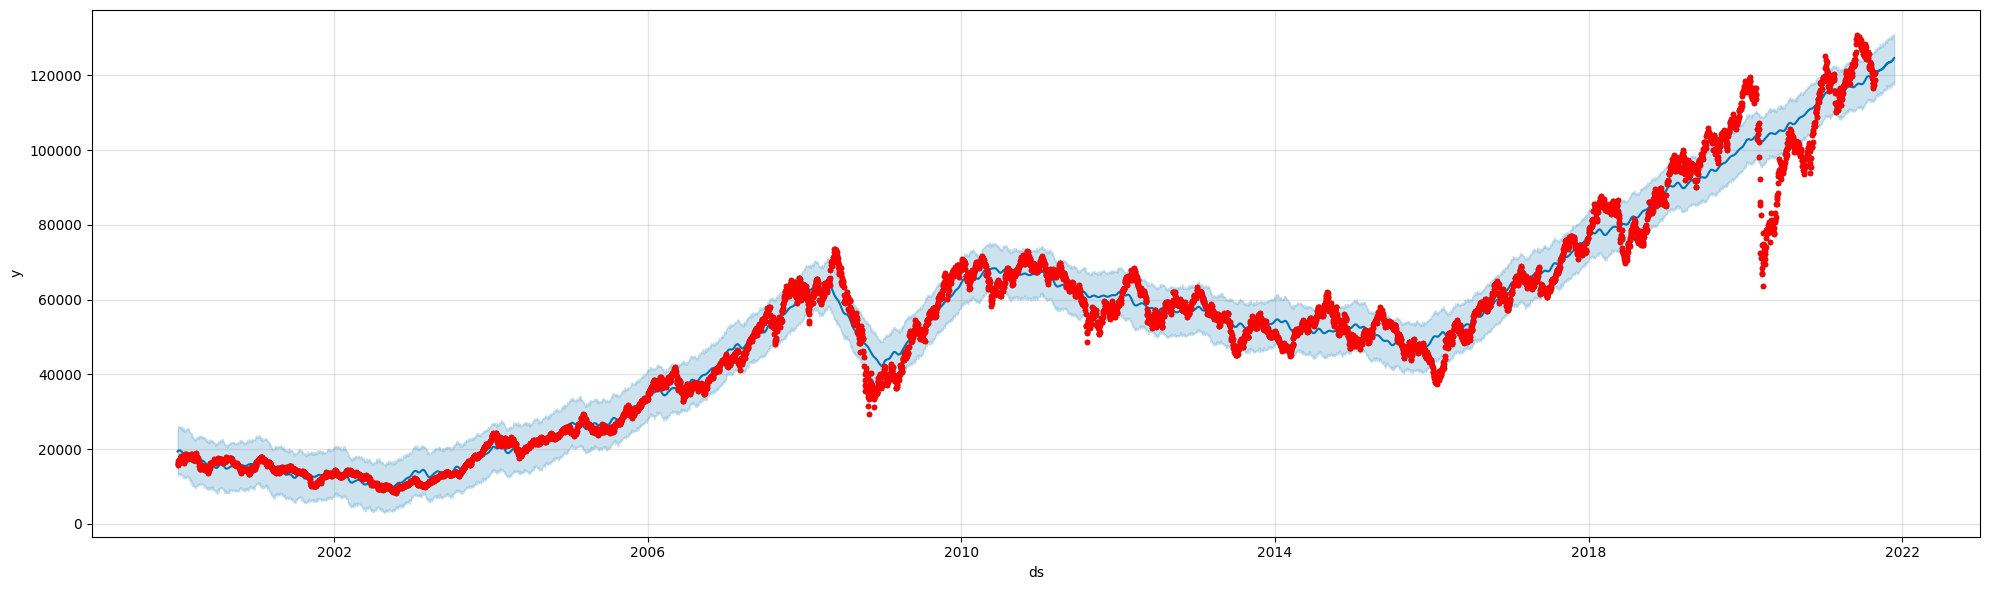

In [38]:
modelo.plot(previsao, figsize=(20,6))
plt.plot(treino['ds'], treino['y'], '.r')

Verificando a qualidade do modelo

In [39]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = treino[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 6.82%


**Percebemos que o nosso MAPE ficou em 6.82%, o que está adequado dada a premissa do projeto**, no entanto, faremos mais algumas análises.

Refizemos esse mesmo modelo, porém com um dataset menor (últimos 2 anos)

In [40]:
df_prophet_2_anos = df_prophet[-730:]

In [41]:
#Separando em base de treino e teste

split_point = int(len(df_prophet_2_anos) * 0.9)
treino_dois_anos = df_prophet_2_anos.iloc[:split_point]
valid_2_anos = df_prophet_2_anos.iloc[split_point:]
print(f'Treino : {treino_dois_anos.shape}')
print(f'Valid: {valid_2_anos.shape}')

Treino : (657, 2)
Valid: (73, 2)


In [42]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(treino_dois_anos)
dataFramefuture = modelo.make_future_dataframe(periods=90, freq='D')
previsao_2_anos = modelo.predict(dataFramefuture)
previsao_2_anos.head()

18:56:35 - cmdstanpy - INFO - Chain [1] start processing
18:56:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-17,119316.491448,112321.846780,118067.932505,119316.491448,119316.491448,-4055.238124,-4055.238124,-4055.238124,-1750.520457,...,-14.522436,-14.522436,-14.522436,-2290.195231,-2290.195231,-2290.195231,0.0,0.0,0.0,115261.253324
1,2021-02-18,119360.317806,112382.465547,118167.461573,119360.317806,119360.317806,-4200.669024,-4200.669024,-4200.669024,-1750.520457,...,-32.358690,-32.358690,-32.358690,-2417.789878,-2417.789878,-2417.789878,0.0,0.0,0.0,115159.648782
2,2021-02-19,119404.144164,112293.983614,117961.107076,119404.144164,119404.144164,-4297.210170,-4297.210170,-4297.210170,-1750.520457,...,-0.990217,-0.990217,-0.990217,-2545.699495,-2545.699495,-2545.699495,0.0,0.0,0.0,115106.933995
3,2021-02-22,119535.623239,111809.667502,117520.435513,119535.623239,119535.623239,-4858.619976,-4858.619976,-4858.619976,-1750.520457,...,-177.962889,-177.962889,-177.962889,-2930.136630,-2930.136630,-2930.136630,0.0,0.0,0.0,114677.003264
4,2021-02-23,119579.449597,111784.153172,117739.874790,119579.449597,119579.449597,-5020.804778,-5020.804778,-5020.804778,-1750.520457,...,-211.796443,-211.796443,-211.796443,-3058.487878,-3058.487878,-3058.487878,0.0,0.0,0.0,114558.644820


c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



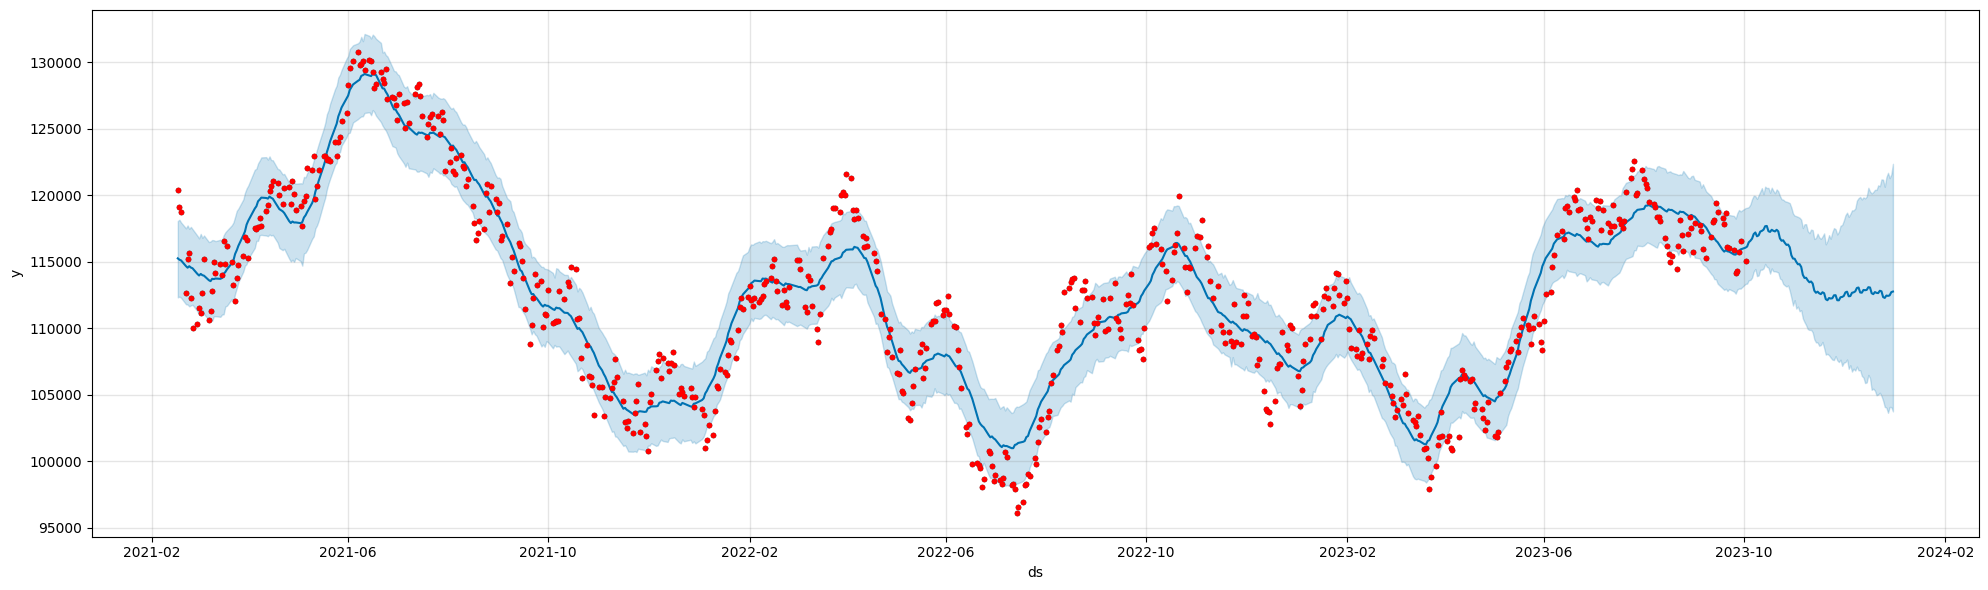

In [43]:
modelo.plot(previsao_2_anos, figsize=(20,6))
plt.plot(treino_dois_anos['ds'], treino_dois_anos['y'], '.r')

Decompondo a série para visualizarmos seus componentes

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old beh

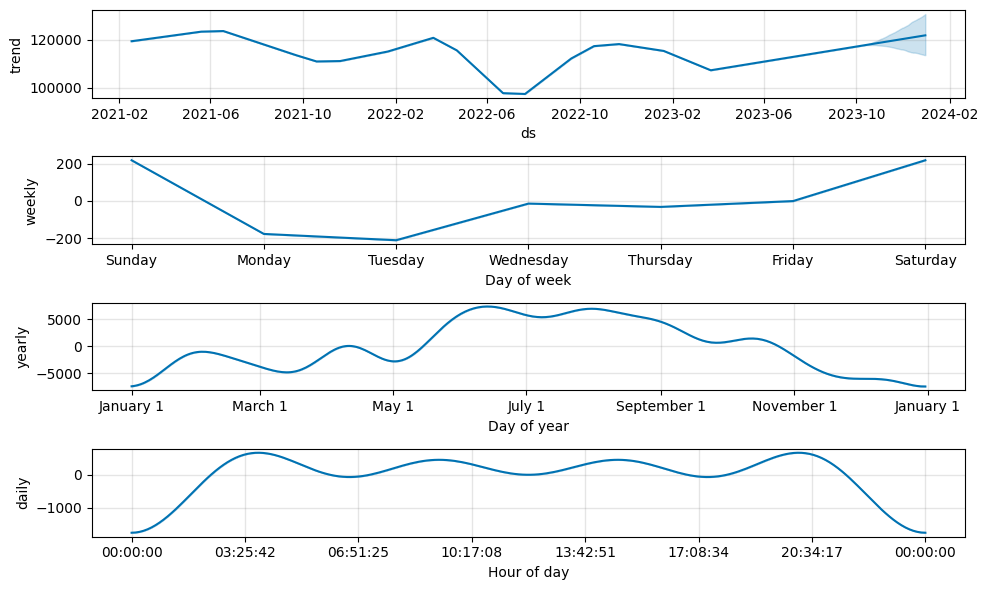

In [44]:
modelo.plot_components(previsao_2_anos, figsize=(10,6));

In [45]:

# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao_2_anos[previsao_cols]
valores_reais = treino_dois_anos[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao_2_anos, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 1.65%


Como podemos ver com a comparação dos resultados de MAPE, o modelo utilizando apenas os dois últimos anos de dados se comporta melhor do que o modelo utilizando a base inteira do IBOVESPA. 

# 5. Conclusão

Concluímos que modelos clássicos de séries temporais, como Média Móvel e ARIMA, enfrentam limitações significativas ao abordar a complexidade inerente à previsão do índice da bolsa de valores. Em contrapartida, modelos mais avançados e adaptativos, como o Prophet e potencialmente redes neurais como o LSTM (não exploradas neste trabalho), demonstram uma capacidade superior para capturar a dinâmica deste mercado.

Especificamente, o modelo Prophet se mostrou uma solução notavelmente eficaz, evidenciado pelos baixos erros de previsão observados. Este resultado sublinha a importância de alinhar a sofisticação do modelo com a complexidade dos dados envolvidos.

Adicionalmente, nossa análise destacou a importância crítica de uma abordagem metodológica na divisão dos dados em conjuntos de treino e teste. Observamos que uma divisão sequencial respeita e preserva a autocorrelação temporal dos dados, um fator chave na precisão do modelo. Em contraste, uma divisão arbitrária ou não cronológica resultou em um aumento nos erros de previsão.

Outro insight relevante foi a influência da dimensão temporal dos dados na eficácia do modelo. Dados mais condensados, excluindo períodos de volatilidade extrema, como as quedas marcantes do índice em 2009 e 2020, contribuíram para uma modelagem mais precisa. Isto sugere que períodos de anomalias financeiras podem distorcer o comportamento geral do índice e, consequentemente, afetar a performance do modelo.

Em resumo, este trabalho reafirma a necessidade de uma escolha cuidadosa e criteriosa tanto do modelo de previsão quanto da estratégia de divisão dos dados, para garantir uma análise robusta e resultados confiáveis na previsão de séries temporais complexas, como é o caso do índice da bolsa de valores.